# Bag of Visual Words (BoW) Classifier

*Marco Tallone*\
*Scientific and Data-Intensive Computing (SDIC) - UniTS*\
*Computer Vision and Pattern Recognition (CVPR) Exam Project*\
*2024/2025*

This notebboks presents an implementation of an image classifier based on the Bag of Visual Words (BoW) approach. More specifically, the overall objective of this project is to build and test a classifier for scene recognition. Throughout the notebook a few classiers are tested, mostly based on $k$-Nearest Neighbors (KNN) and Support Vector Machines (SVM) with different strategies.\
The notebook is structured as follows:

1. **Imports**: general set-up and import of libraries, modules and utility functions
2. **Data Exploration**: prelimirary analysis of the dataset
3. **Feature Extraction**: extraction of features from the images
4. **Clustering**: clustering of the features to build a visual vocabulary
5. **Image Representation**: representation of the images as histograms of visual words
6. **Classification**: implementation and testing of the classifiers

For a theoretical explanation of the project and a full result analysis please refer to the report.

## Imports

First of all, we load all the necessary modules and utility functions that has been defined in the `utils.py` file to improve the readability of the notebook. All the functions are documented in the file and further information can be retrieved by calling the `help()` function on them.\
We also need to set the location of the dataset relative to the notebook in order to load the images and the labels.

In [2]:
# import modules and utility functions
from utils import *

# Constants
DATASET_DIR = "../datasets"
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
TEST_DIR = os.path.join(DATASET_DIR, "test")

Imported libraries:
	- Numpy version: 1.26.4
	- OpenCV version: 4.10.0
	- SciKit-Learn version: 1.6.1
	- SciPy version: 1.15.1

Imported functions:
	- load_images()
	- compute_descriptors()
	- intersection_kernel()
	- normalized_histogram()
	- tfidf()
	- kcb()
	- unc()
	- pla()
	- pyramid_histogram()


## Data Exploration

The classifiers later implemented will be trained and tested on the $15$ scene dataset by *Lazebnik et al.*. The dataset is a collection $4485$ of images of $15$ different scene categories. This comes already separated in train and test sets.\
We can now load the images and the corresponding labels with the dedicated function.

In [3]:
# Load data
train_images, train_labels, classes = load_images(TRAIN_DIR)
test_images,  test_labels, 	_       = load_images(TEST_DIR)

# Data information
print(f"Number of classes: {len(classes)}")
print(f"Number of training images: {len(train_images)}")
print(f"Number of test images: {len(test_images)}")

Loading images:   0%|          | 0/15 [00:00<?, ?it/s]

Loading images:   0%|          | 0/15 [00:00<?, ?it/s]

Number of classes: 15
Number of training images: 1500
Number of test images: 2985


We can plot the number of images for each class both for the training and testing sets to check their distribution.

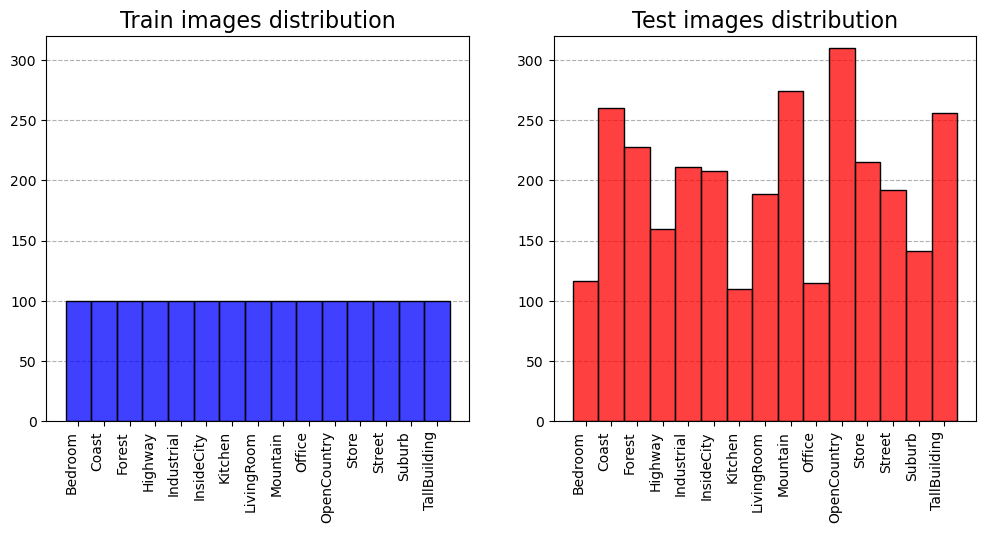

In [8]:
# Classes distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 5))


plt.rcParams["text.usetex"] = True
sns.histplot(train_labels, bins=len(classes), ax=ax[0], color="blue", binrange=[0, len(classes)], binwidth=1, zorder=2)
ax[0].set_title("Train images distribution", fontsize=16)
ax[0].set_xticks([i + 0.5 for i in range(len(classes))])
ax[0].set_xticklabels(classes, rotation=90, ha='right')
ax[0].set_ylabel("")
ax[0].set_ylim(0, 320)
ax[0].grid(axis='y', linestyle='--', zorder=1)

sns.histplot(test_labels, bins=len(classes), ax=ax[1], color="red", binrange=[0, len(classes)], binwidth=1, zorder=2)
ax[1].set_title("Test images distribution", fontsize=16)
ax[1].set_xticks([i + 0.5 for i in range(len(classes))])
ax[1].set_xticklabels(classes, rotation=90, ha='right')
ax[1].set_ylabel("")
ax[1].set_ylim(0, 320)
ax[1].grid(axis='y', linestyle='--', zorder=1)

plt.show()

As we can see we have a uniform distribution of $100$ images for each of the $15$ classes in the training set, while a total of $2985$ images non-uniformly distributed are available in the testing set.

We can also see that the images have different sizes and aspect ratios by looking at the following plots. We might keep this in mind as this will affect the total number of keypoints extracted from each image.

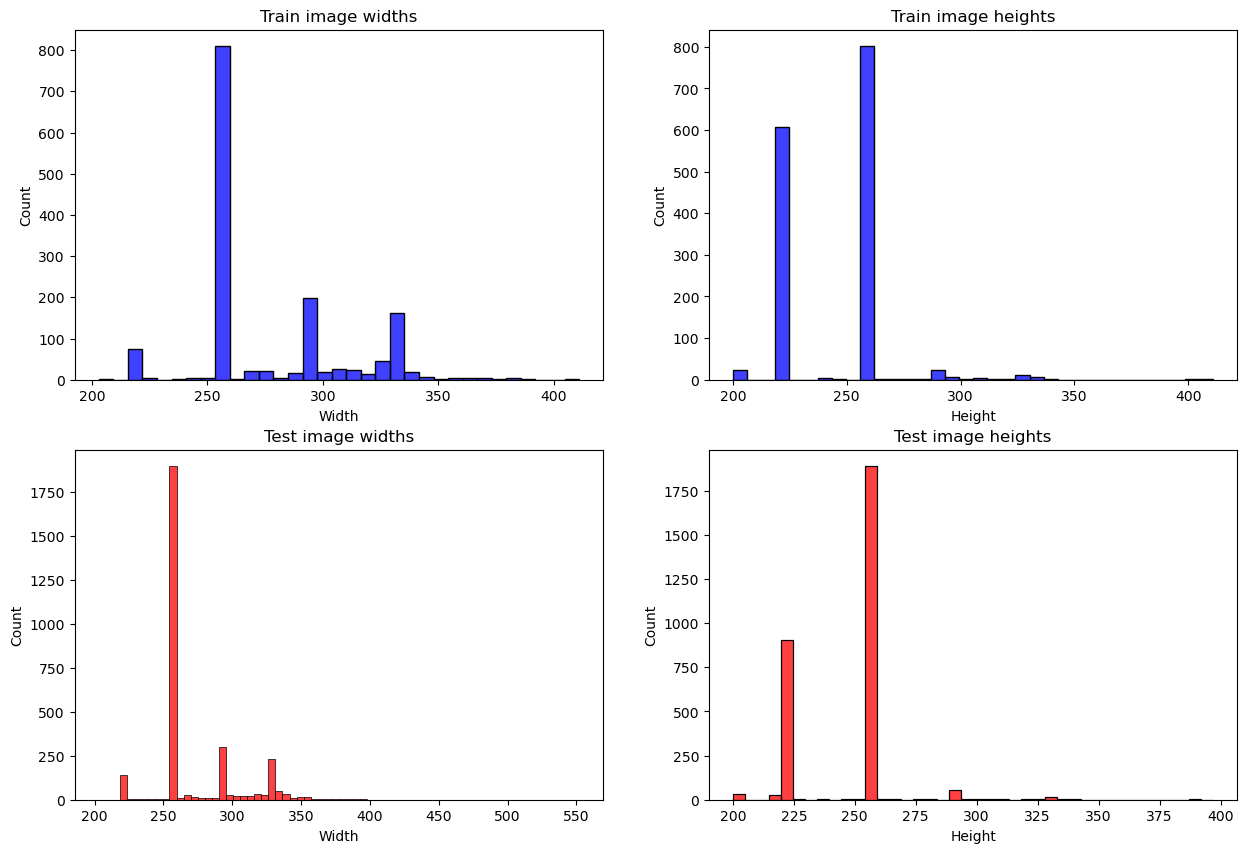

In [6]:
# Sizes of the images

# Measure image sizes
train_widths = [image.shape[1] for image in train_images]
train_heights = [image.shape[0] for image in train_images]
test_widths = [image.shape[1] for image in test_images]
test_heights = [image.shape[0] for image in test_images]

# Plot the image sizes
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

sns.histplot(train_widths, ax=ax[0, 0], color="blue")
ax[0, 0].set_title("Train image widths")
ax[0, 0].set_xlabel("Width")
ax[0, 0].set_ylabel("Count")

sns.histplot(train_heights, ax=ax[0, 1], color="blue")
ax[0, 1].set_title("Train image heights")
ax[0, 1].set_xlabel("Height")
ax[0, 1].set_ylabel("Count")

sns.histplot(test_widths, ax=ax[1, 0], color="red")
ax[1, 0].set_title("Test image widths")
ax[1, 0].set_xlabel("Width")
ax[1, 0].set_ylabel("Count")

sns.histplot(test_heights, ax=ax[1, 1], color="red")
ax[1, 1].set_title("Test image heights")
ax[1, 1].set_xlabel("Height")
ax[1, 1].set_ylabel("Count")

plt.show()

## Feature Extraction

Before implementing any classifier, the first objective of this project is to build a visual vocabulary of visual words. In this context the visual vocabulary will actually be obtained from a set of features extracted from the images, in particular from SIFT descriptors. Therefore, visual words will be $128$-dimensional vectors representing the SIFT descriptors (*more precisely the centroids resulting from the clustering of the SIFT descriptors as explained below*).\
Hence, we need to sample SIFT descriptors from the train set images and this can be done in two ways:

1. **SIFT Detector**: use the SIFT detector to extract keypoints and then compute the SIFT descriptors for each keypoint
2. **Grid Sampling**: sample SIFT descriptors on a regular grid with spacing of $8$ pixels between keypoints over the image

We will mainly focus on the second strategy in this notebook since it produces better results but at least one comparison of performance between the two is given below. FOr a full analysis of the results obtained with both methods, please refer to the report present in this repository.\
The implemented function `compute_descriptors()` allows to extract SIFT descriptors from the images using the `sift.detectAndCompute()` function from the `cv2` module. The function returns two arguments: an array of all the descriptors extracted from all the images and a list containing the descriptors for each image. By passing the correct input arguments we can perform both feature extraction strategies.
We initialize a dictionary to keep track of the descriptors extracted in the two cases.

In [7]:
# Initialize SIFT detector and descriptor
FEATURES = 500
sift = cv2.SIFT_create(FEATURES)
descriptors = {}
train_descriptors = {}

# Feature extraction for train images

# Compute descriptors from detected keypoints
all_descriptors, per_image_descriptors = compute_descriptors(train_images, sift)
descriptors["detected"] = all_descriptors
train_descriptors["detected"] = per_image_descriptors

# Compute descriptors from dense grid of keypoints
all_descriptors, per_image_descriptors = compute_descriptors(train_images, sift, grid=True)
descriptors["grid"] = all_descriptors
train_descriptors["grid"] = per_image_descriptors

# Print number of descriptors
for key, descriptor in descriptors.items():
	print(f"Number of {key} SIFT descriptors: {len(descriptor)}")

Computing descriptors:   0%|          | 0/1500 [00:00<?, ?it/s]

Computing descriptors:   0%|          | 0/1500 [00:00<?, ?it/s]

Number of detected SIFT descriptors: 593006
Number of grid SIFT descriptors: 1482434


Notice above that we decided to keep only the best $500$ keypoints detected in each image, but the number of keypoints depends on the number of features actually detected by the SIFT detector in each image, which, depending on the scene portrayed, might be less than the chosen value. The two examples below portray this situation: image $1$ has only $30$ keypoints detected, while image $2$ has $500$ keypoints detected.

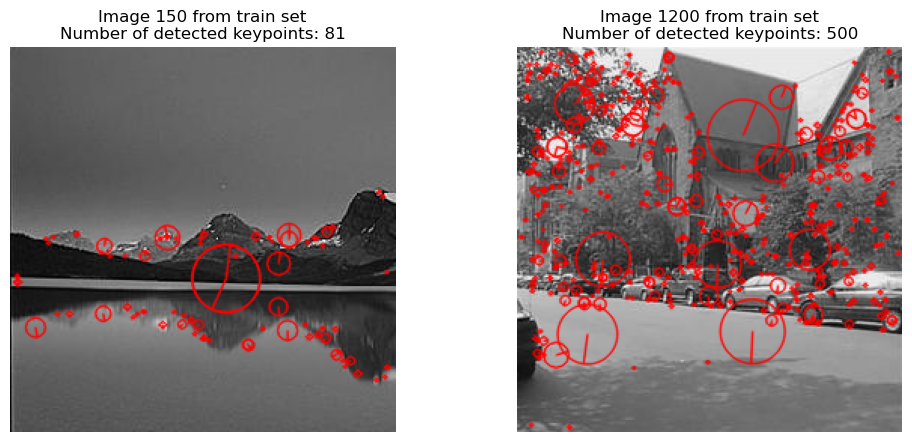

In [17]:
# Keypoints for 2 sample images
i1 = 150
i2 = 1200
image1 = train_images[i1]
image2 = train_images[i2]
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

# Draw keypoints on the images
image_keypoints1 = cv2.drawKeypoints(
	image1, 
	keypoints1, 
	outImage=None,
	color=(255, 0, 0),
	flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)
image_keypoints2 = cv2.drawKeypoints(
	image2,
	keypoints2,
	outImage=None,
	color=(255, 0, 0),
	flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].imshow(image_keypoints1)
ax[0].set_title(f"Image {i1} from train set\nNumber of detected keypoints: {len(keypoints1)}")
ax[0].axis("off")
ax[1].imshow(image_keypoints2)
ax[1].set_title(f"Image {i2} from train set\nNumber of detected keypoints: {len(keypoints2)}")
ax[1].axis("off")

plt.show()

However, by plotting the distribution of keypoints detected in the traning images we can see that the desired number of keypoints has been detected in most of the images while for grid sampling this is around $1000$ keypoints per image with slight differences between the images due to the different aspect ratios and sizes.

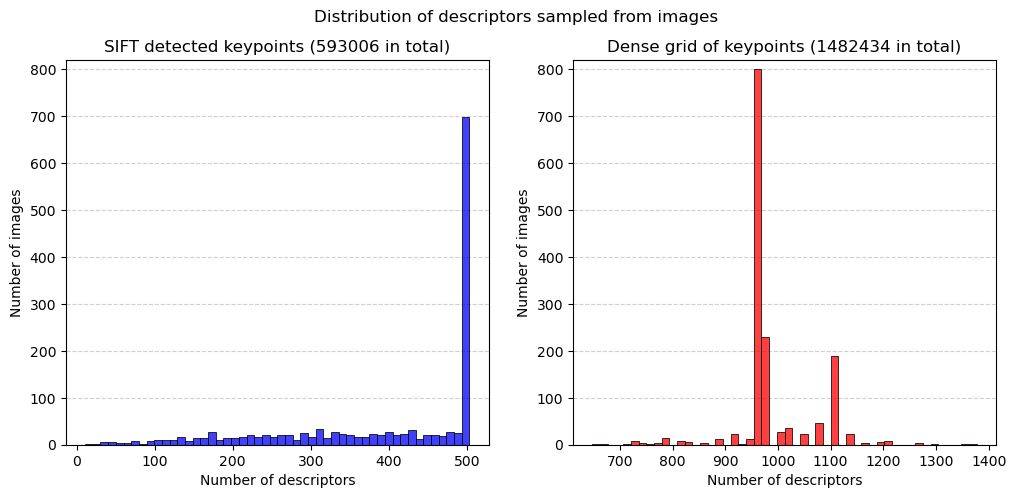

In [18]:
# Distributions of points sampled in images

# Count the number of descriptors per image
n_descriptors1 = [len(train_descriptors["detected"][i]) for i in range(len(train_images))]
n_descriptors2 = [len(train_descriptors["grid"][i]) for i in range(len(train_images))]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Distribution of descriptors sampled from images")

sns.histplot(n_descriptors1, bins=50, ax=ax[0], color="blue", zorder=2)
ax[0].set_title(f"SIFT detected keypoints ({sum(n_descriptors1)} in total)")
ax[0].set_xlabel("Number of descriptors")
ax[0].set_ylabel("Number of images")
ax[0].set_ylim(0, 820)
ax[0].grid(axis='y', linestyle='--', alpha=0.6, zorder=1)

sns.histplot(n_descriptors2, bins=50, ax=ax[1], color="red", zorder=2)
ax[1].set_title(f"Dense grid of keypoints ({sum(n_descriptors2)} in total)")
ax[1].set_xlabel("Number of descriptors")
ax[1].set_ylabel("Number of images")
ax[1].set_ylim(0, 820)
ax[1].grid(axis='y', linestyle='--', alpha=0.6, zorder=1)

plt.show()

## Clustering

In the process of building a visual vocabulary we then perform K-Means clustering on the extracted features. 
Clustering is here performed on a random subset of the extracted features of fixed size for computational efficiency (*and since, after a series of tests, the final results don't seem to change significantly*). To keep more or less the same ration between total number of descriptors and descriptors used for clustering, we set the size of the random subset to $10000$ for descriptors extracted by SIFT detector and to $25000$ for descriptors extracted by grid sampling.\
The number of clusters is a hyperparameter that needs to be tuned: in this case we can decide to fix it to $400$ to guarantee the possibility to compare results with the original paper by *Lazebnik et al.* and *Van Gemert et al.*.

In [19]:
# Random subset of descriptors
np.random.seed(3)
n_samples = {
	"detected": 10000,	# for detected keypoints
	"grid": 	25000	# for dense grid of keypoints 
}

sample_indices = {
	key: np.random.choice(len(descriptors[key]), n_samples[key], replace=False)
	for key in descriptors
}

sample_descriptors = {
	key: descriptors[key][sample_indices[key]]
	for key in descriptors
}

# Number of clusters
K = 400

# Clustering
kmeans = {
	key: KMeans(n_clusters=K, random_state=42)
	for key in descriptors
}

for key in descriptors:
	kmeans[key].fit(sample_descriptors[key])

We can analyze the distribution of the visual vocabulary to see if some clusters are more populated than others. This is important to understand the quality of clustering as well as the global frequency of the visual words in the dataset.

In [ ]:
# Visual words distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Visual words distribution")

# Detected case
sns.histplot(kmeans["detected"].labels_, bins=K, ax=ax[0], color="blue", zorder=2)
ax[0].set_title("SIFT detected")
ax[0].set_xlabel("Visual words")
ax[0].set_ylabel("Number of descriptors")
ax[0].set_ylim(0, 200)
ax[0].grid(axis='y', linestyle='--', zorder=1)

# Grid case
sns.histplot(kmeans["grid"].labels_, bins=K, ax=ax[1], color="red", zorder=2)
ax[1].set_title("Grid sampling")
ax[1].set_xlabel("Visual words")
ax[1].set_ylabel("Number of descriptors")
ax[1].set_ylim(0, 200)
ax[1].grid(axis='y', linestyle='--', zorder=1)

plt.show()

Moreover we approximate the region around each centroid in the clusters as the set of descriptors having Euclidean norm smaller or equal than the maximum distance between each cluster centroid and the furtherst descriptor assigned to its cluster. This will be useful later for soft assignment techniques.

In [ ]:
# Initialize a dictionary to store the radius of each cluster in both cases
radius = {
	"detected": np.zeros(K),
	"grid": np.zeros(K)
}

# Detected case
centroids = kmeans["detected"].cluster_centers_
for descriptor in tqdm.tqdm(descriptors["detected"], desc="Computing cluster radius detected case", leave=False):
	label = kmeans["detected"].predict(descriptor.reshape(1, -1))[0]
	distance = np.linalg.norm(descriptor - centroids[label])
	radius["detected"][label] = max(radius["detected"][label], distance) # only keep the maximum distance

# Grid case
centroids = kmeans["grid"].cluster_centers_
for descriptor in tqdm.tqdm(descriptors["grid"], desc="Computing cluster radius grid case", leave=False):
	label = kmeans["grid"].predict(descriptor.reshape(1, -1))[0]
	distance = np.linalg.norm(descriptor - centroids[label])
	radius["grid"][label] = max(radius["grid"][label], distance) # only keep the maximum distance

Computing cluster radius detected case:   0%|          | 0/593006 [00:00<?, ?it/s]

Computing cluster radius grid case:   0%|          | 0/1482434 [00:00<?, ?it/s]

## Image Representations

Now we need to represent the images as fixed length vectors of visual words. This can be done in multiple ways as explained in the report. Dedicated functions used below have been implemented in the `utils.py` file to conver each set of images in the training and testing sets to a corresponding set of reèresentations.

⚠ **Notice**: running all these cells might take a lot of time and computational resources. For this reason, the computed representations have been storted using the `pickle` module and can be loaded directly from the file by setting the `LOAD = True` variable below. However, due to the size of the files and for [safety reasons related to the module (see link)](https://docs.python.org/3/library/pickle.html) the files are not included in the repository, but can be provided upon request.

In [ ]:
# Variable to load from file
LOAD = False

In [ ]:
# Normalized Histogram representation
if not LOAD:
	train_histograms = {
		"detected": normalized_histogram(train_images, sift, kmeans["detected"]),
		"grid": normalized_histogram(train_images, sift, kmeans["grid"], grid=True)
	}
	test_histograms = {
		"detected": normalized_histogram(test_images, sift, kmeans["detected"]),
		"grid": normalized_histogram(test_images, sift, kmeans["grid"], grid=True)
	}
else:
	with open("train_histograms.pkl", "rb") as f:
		train_histograms = pickle.load(f)

	with open("test_histograms.pkl", "rb") as f:
		test_histograms = pickle.load(f)

In [ ]:
# TF-IDF representation
if not LOAD:
	train_tfidf = {	
		"detected": tfidf(train_images, sift, kmeans["detected"]),
		"grid": tfidf(train_images, sift, kmeans["grid"], grid=True)
	}
	test_tfidf = {
		"detected": tfidf(test_images, sift, kmeans["detected"]),
		"grid": tfidf(test_images, sift, kmeans["grid"], grid=True)
	}
else:
	with open("train_tfidf.pkl", "rb") as f:
		train_tfidf = pickle.load(f)
  
	with open("test_tfidf.pkl", "rb") as f:
		test_tfidf = pickle.load(f)

In [ ]:
# Kernel codebook representation
if not LOAD:
	train_kcb = {
		"detected": kcb(train_images, sift, kmeans["detected"]),
		"grid": kcb(train_images, sift, kmeans["grid"], grid=True)
	}
	test_kcb = {
		"detected": kcb(test_images, sift, kmeans["detected"]),
		"grid": kcb(test_images, sift, kmeans["grid"], grid=True)
	}
else:
	with open("train_kcb2.pkl", "rb") as f:
		train_kcb = pickle.load(f)
  
	with open("test_kcb2.pkl", "rb") as f:
		test_kcb = pickle.load(f)

In [ ]:
# Codeword uncertainty representation
if not LOAD:
	train_unc = {
		"detected": unc(train_images, sift, kmeans["detected"]),
		"grid": unc(train_images, sift, kmeans["grid"], grid=True)
	}
	test_unc = {
		"detected": unc(test_images, sift, kmeans["detected"]),
		"grid": unc(test_images, sift, kmeans["grid"], grid=True)
	}
else:
	with open("train_unc2.pkl", "rb") as f:
		train_unc = pickle.load(f)

	with open("test_unc2.pkl", "rb") as f:
		test_unc = pickle.load(f)

In [ ]:
# Codeword plausibility representation
if not LOAD:
	train_pla = {
		"detected": pla(train_images, sift, kmeans["detected"]),
		"grid": pla(train_images, sift, kmeans["grid"], grid=True)
	}
	test_pla = {
		"detected": pla(test_images, sift, kmeans["detected"]),
		"grid": pla(test_images, sift, kmeans["grid"], grid=True)
	}
else:
	with open("train_pla2.pkl", "rb") as f:
		train_pla = pickle.load(f)
  
	with open("test_pla2.pkl", "rb") as f:
		test_pla = pickle.load(f)

In [ ]:
# Spatial pyramid histogram representation
if not LOAD:
	LEVELS = range(0, 3)
	train_pyramid = {
		"grid": pyramid_histogram(train_images, sift, kmeans["grid"], levels=LEVELS)
	}
	test_pyramid = {
		"grid": pyramid_histogram(test_images, sift, kmeans["grid"], levels=LEVELS)
	}    
else:
	with open("train_pyramid.pkl", "rb") as f:
		train_pyramid = pickle.load(f)
  
	with open("test_pyramid.pkl", "rb") as f:
		test_pyramid = pickle.load(f)

For practical reasons to compute the results later we form a dictionaries containing the representations of the images for both the training and testing sets.

In [ ]:
# Form a list with all representations
names = [
	"Normalized Histogram",
	"TF-IDF",
	"Kernel Codebook",
	"Codeword Uncertainty",
	"Codeword Plausibility",
]

train_representations = [
	train_histograms,
	train_tfidf,
	train_kcb,
	train_unc,
	train_pla,
]

test_representations = [
	test_histograms,
	test_tfidf,
	test_kcb,
	test_unc,
	test_pla,
]

# Results dictionary
results = {
	"dummy": {
		"detected": {name: {} for name in names},
		"grid": {name: {} for name in names}
	},
	"1nn": {
		"detected": {name: {} for name in names},
		"grid": {name: {} for name in names}
	},
	"knn": {
		"detected": {name: {} for name in names},
		"grid": {name: {} for name in names}
	},
	"svm_rbf": {
		"detected": {name: {} for name in names},
		"grid": {name: {} for name in names}
	},
	"svm_chi2": {
		"detected": {name: {} for name in names},
		"grid": {name: {} for name in names}
	},
	"svm_intersection": {
		"detected": {name: {} for name in names},
		"grid": {name: {} for name in names}
	},
	"svm_pyramid": {
		"grid": {name: {} for name in names}
	}
}

After having computed the normalized histogram representation (HIST) for each image, we can plot for each possible class the corresponding histogram for a sample training image and a sample test image of that clas to visually check if any similarity can be observed.

Train indexes:   0%|          | 0/15 [00:00<?, ?it/s]

Test indexes:   0%|          | 0/15 [00:00<?, ?it/s]

Computing chi-square distances and intersections:   0%|          | 0/15 [00:00<?, ?it/s]

Plotting histograms: 0it [00:00, ?it/s]

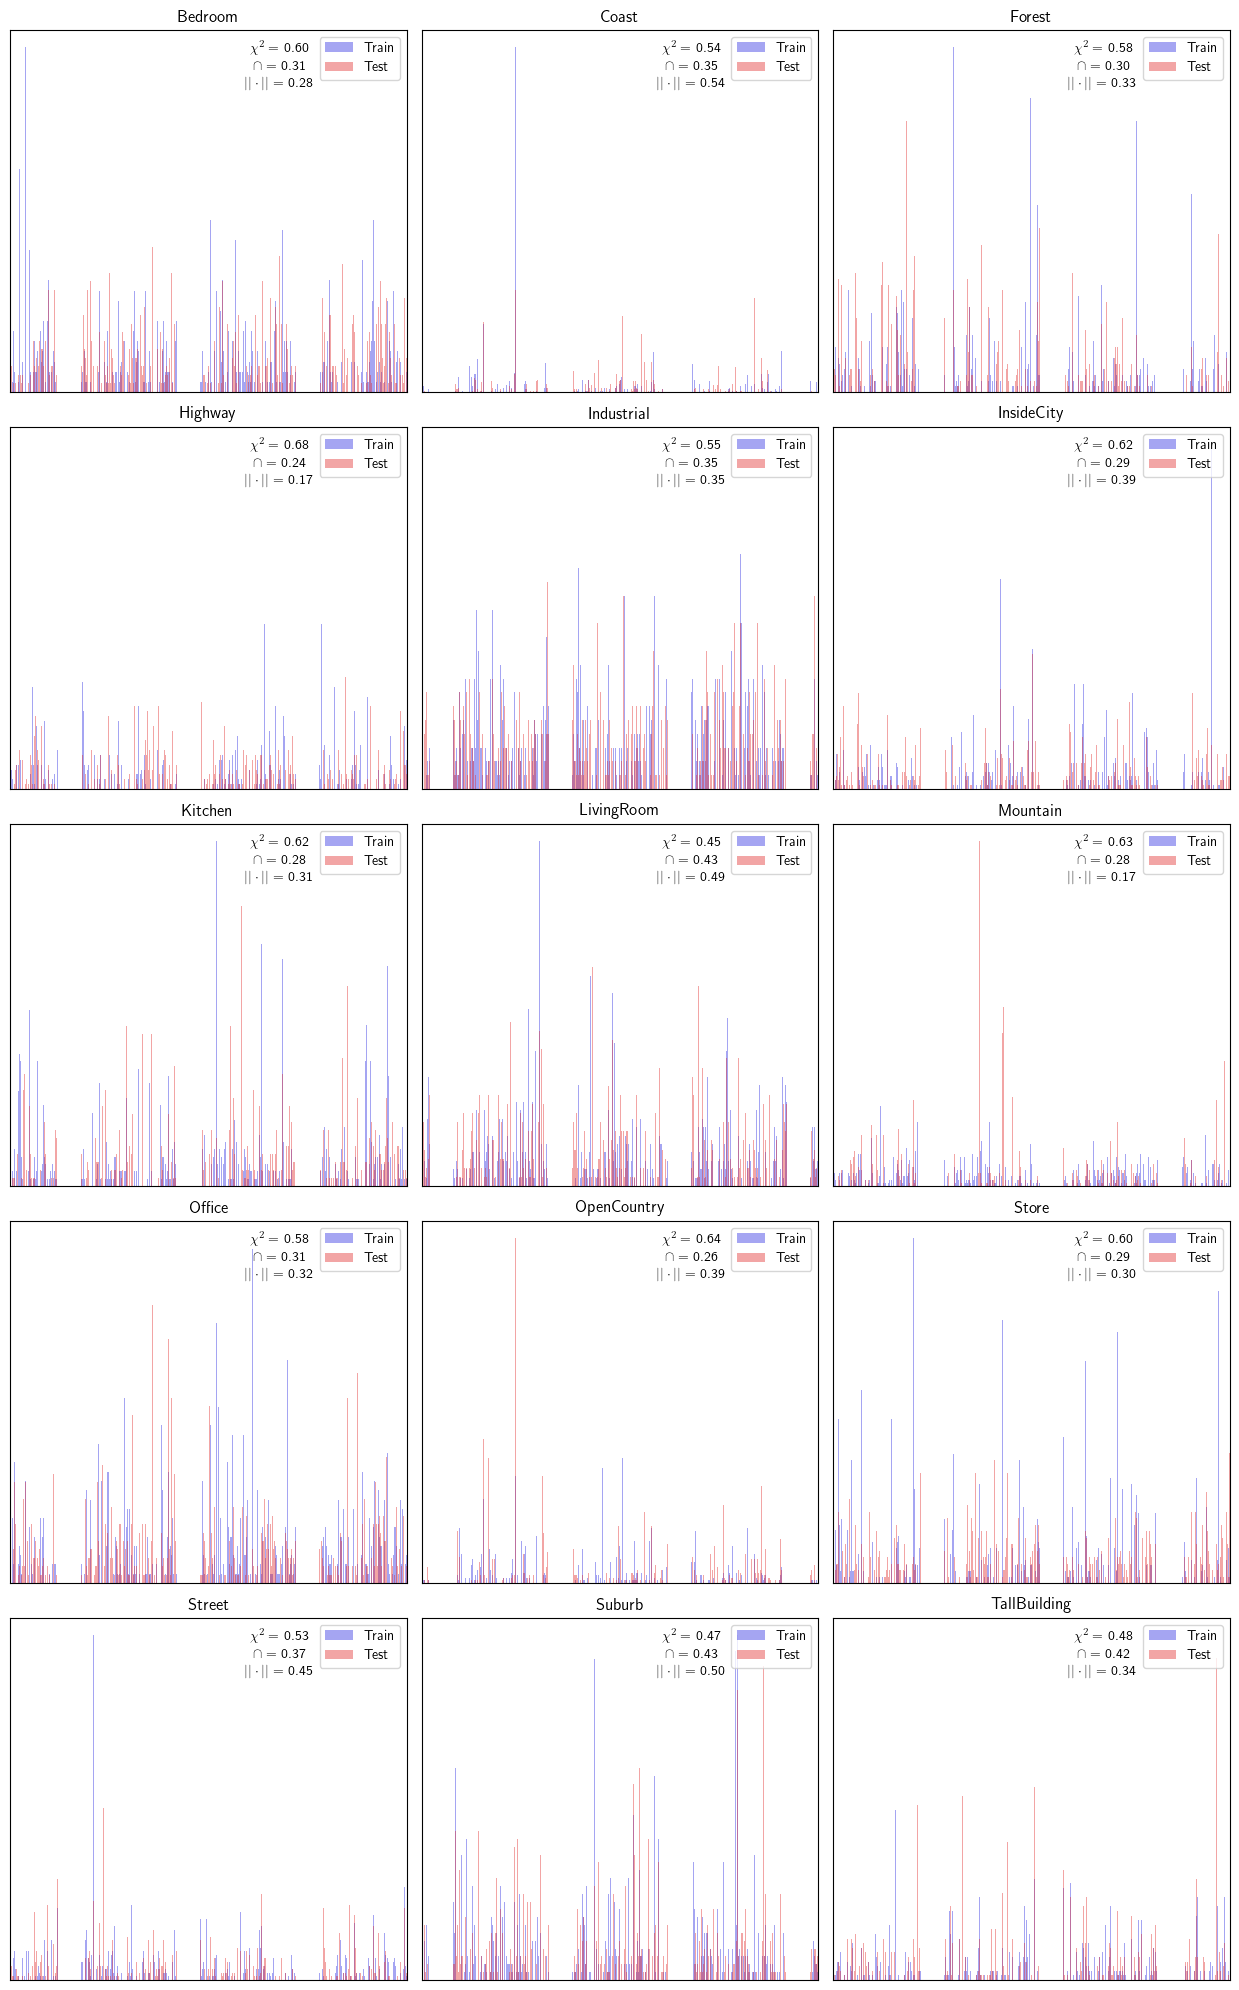

In [ ]:
# Pick a pair of train/test images for each possible class
train_indexes = {class_name: [] for class_name in classes}
test_indexes = {class_name: [] for class_name in classes}

for label in tqdm.tqdm(set(train_labels), desc="Train indexes", leave=False):
	for i, _ in enumerate(train_labels):
		if train_labels[i] == label:
			train_indexes[classes[label]].append(i)
			break

for label in tqdm.tqdm(set(test_labels), desc="Test indexes", leave=False):
	for i, _ in enumerate(test_labels):
		if test_labels[i] == label:
			test_indexes[classes[label]].append(i)
			break

# Collect relative histograms
h_train = []
h_test = []
for class_name in tqdm.tqdm(classes, desc="Collecting histograms", leave=False):
	i_train = train_indexes[class_name][0]
	i_test = test_indexes[class_name][0]
	h_train.append(train_histograms["grid"][i_train])
	h_test.append(test_histograms["grid"][i_test])

# Compute chi-square distances, intersection and cosine similarity
def intersection(h1, h2):
	return np.sum(np.minimum(h1, h2))

def chi2_distance(h1, h2):
	return 0.5*np.sum((h1 - h2)**2 / (h1 + h2 + 1e-6))

def cosine_similarity(h1, h2):
	return np.dot(h1, h2) / (np.linalg.norm(h1) * np.linalg.norm(h2))

chi2_distances = np.zeros((len(classes), len(classes)))
intersections = np.zeros((len(classes), len(classes)))
similarities = np.zeros((len(classes), len(classes)))
for i in tqdm.tqdm(range(len(classes)), desc="Computing chi-square distances and intersections", leave=False):
	for j in range(len(classes)):
		chi2_distances[i, j] = chi2_distance(h_train[i], h_test[j])
		intersections[i, j] = intersection(h_train[i], h_test[j])
		similarities[i, j] = cosine_similarity(h_train[i], h_test[j])

# Plot
fig, ax = plt.subplots(5, 3, figsize=(12.5, 20))
ax = ax.flatten()

# Each subplot is one class (train and test histograms with transparency)
for i, class_name in tqdm.tqdm(enumerate(classes), desc="Plotting histograms", leave=False):
	sns.barplot(x=np.arange(K), y=h_train[i], ax=ax[i], color="blue", alpha=0.4, label="Train")
	sns.barplot(x=np.arange(K), y=h_test[i], ax=ax[i], color="red", alpha=0.4, label="Test")
	ax[i].set_title(f"{class_name}")
	ax[i].set_xticks([])
	ax[i].set_yticks([])
	ax[i].legend(loc='upper right')
	ax[i].text(0.68, 0.95, r"$\chi^2 =$ " f"{chi2_distances[i, i]:.2f}", horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes)
	ax[i].text(0.68, 0.90, r"$\cap =$ " f"{intersections[i, i]:.2f}", horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes)
	ax[i].text(0.68, 0.85, r"$||\cdot|| =$ " f"{similarities[i, i]:.2f}", horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes)
				 
plt.tight_layout()
plt.show()  

Among the representation functions, the implementations details of the ones for the soft assignment techniques deserves to be properly explained. Given the high dimensionality of the data we can explain the implementation details of the Kernel Codebook method () with a dummy example below, where we assume that features have lower dimensionality for simplicity. The theoretical details explained in the paper, but this function basically implements this method for every image:

$$
\begin{equation}
	h_i = \frac{1}{n_{ri}} \sum_{j=0}^{n_{ri}} K_{\sigma}(D(w_i, x_j)),
	\quad
	\forall i \in \{0, \ldots, K-1\},
	\forall d \in \{0, \ldots, N-1\}
\end{equation}
$$

where $K_{\sigma}$ is the Gaussian kernel, $D(w_i, x_j)$ is the Euclidean distance between the $i$-th cluster centroid and the $j$-th descriptor, $n_{ri}$ is the number of descriptors in the region of the $i$-th cluster centroid and $N$ is the number of images.\
For computational reasons, the `rbf_kernel()` function from the `sklearn` module is used to compute the Gaussian kernel, which internally already uses the Euclidean distance.

In [ ]:
# Assume we have collected the following 3-dimensional descriptors 
# in one of the images of the training set
example_descriptors = np.array([
	[0.2, 0.2, 0.3],
	[0.2, 0.3, 0.4],
	[0.3, 0.5, 0.5]
])

# And, for simplycity, we have the fowllowing 2 centroids for the KMeans
example_centroids = np.array([
	[0.1, 0.2, 0.3],
	[0.3, 0.4, 0.5]
])

# That have the following radius assigned
example_radius = np.array([0.1, 0.2])

# First we can compute the Gaussian kernel between any pair of descriptors and centroids
# using the scikit-learn implementation
example_sigma = 0.1
example_kernel = rbf_kernel(example_centroids, example_descriptors, gamma=1/(2*example_sigma**2))
print("Full kernel matrix:")
print(example_kernel)

# However, as explained in the paper we want only want the descriptors within the radius
# of the centroid to contribute to the kernel computation of each cluster...
# Hence we need to create a masking using the Euclidean distances
example_distances = np.array([np.linalg.norm(example_descriptors - centroid, axis=1) for centroid in example_centroids])

# The we substitute 0 where the distance is greater than the radius, 1 otherwise
for row in range(example_centroids.shape[0]):
	example_distances[row][example_distances[row] > example_radius[row]] = 0
	example_distances[row][example_distances[row] != 0] = 1
 
print("\nEuclidean distances masking:")
print(example_distances)

# Finally we apply the masking and sum along the correct axis to obtain the KCB representation
example_kernel = example_kernel * example_distances
print("\nMasked kernel matrix:")
print(example_kernel)

# Sum along the rows and normalize
example_kcb = np.sum(example_kernel, axis=1)
example_kcb /= np.sum(example_kcb)
print("\nKCB representation:")
print(example_kcb)

Full kernel matrix:
[[6.06530660e-01 2.23130160e-01 2.03468369e-04]
 [1.11089965e-02 2.23130160e-01 6.06530660e-01]]

Euclidean distances masking:
[[1. 0. 0.]
 [0. 1. 1.]]

Masked kernel matrix:
[[0.60653066 0.         0.        ]
 [0.         0.22313016 0.60653066]]

KCB representation:
[0.4223188 0.5776812]


Of course the previus is just a dummy example to explain the implementation and it's actually beign done with the $128$-dimensional features in the implemented `kcb()` function. The `unc()` and `pla()` methods work on a similar concept.\
We can also show the differences between the representation of one image with the Normalized histogram (HIST) and the Kernel Codebook (KCB) representations below.

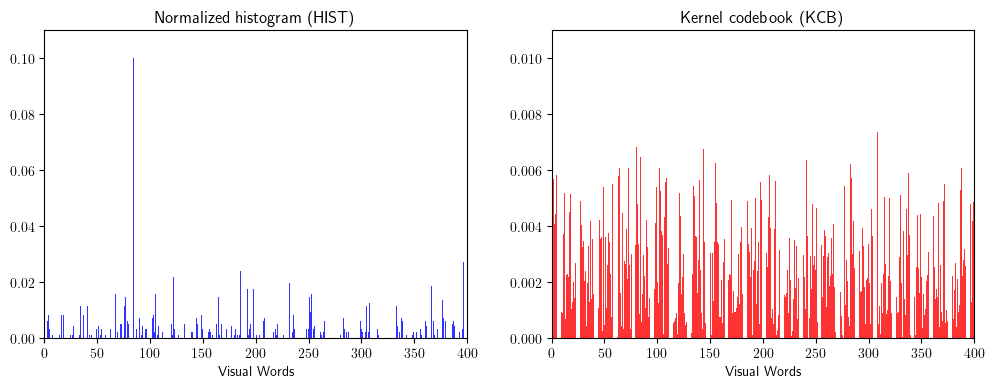

In [ ]:
# Comparison between image representations
idx = 1200 # from train set

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Normalized histogram
histogram_rep = train_histograms["grid"][idx]
ax[0].bar(range(K), histogram_rep, color="blue", alpha=0.8)
ax[0].set_title("Normalized histogram (HIST)")
ax[0].set_xlabel("Visual Words")
ax[0].set_ylabel("")
ax[0].set_xlim(0, K)
ax[0].set_ylim(0, 0.11)

# KCB
kcb_rep = train_kcb["grid"][idx]
ax[1].bar(range(K), kcb_rep, color="red", alpha=0.8)
ax[1].set_title("Kernel codebook (KCB)")
ax[1].set_xlabel("Visual Words")
ax[1].set_ylabel("")
ax[1].set_xlim(0, K)
ax[1].set_ylim(0, 0.011)

plt.show()

As we can see the hard assignment representation (HIST) is more sparse than the one obtained with the Kernel codebook as less descriptors are contributing to the estimation of the distribution of visual words in the image.

## Classification

Now we assess different classifiers on all representations. All classifiers as well as the accuracy computatiopn methods are taken from the `sklearn` module.

### Dummy Classifier

As a baseline for comparison with the later implemented model we can first evaluate the performance of the dummy classifier, which predicts the most frequent class in the test set for each image.

In [ ]:
# Simple function to evaluatte the DUmmy classifier (notice input features are not considered)
def evaluate_dummy(train, test, labels):
	dummy = DummyClassifier(strategy="most_frequent")
	dummy.fit(test, labels)
	dummy_score = dummy.score(test, labels)
	return dummy_score

# For this classifier the result is the same with every representation...
train = train_histograms["grid"]
test = test_histograms["grid"]
accuracy = evaluate_dummy(train, test, test_labels)
print(f"Dummy classifier accuracy: {accuracy*100:.2f}%")

# Fill the results dictionary with the Dummy classifier results
for name in names:
	for key in ["detected", "grid"]:
		results["dummy"][key][name] = accuracy

Dummy classifier accuracy: 10.39%


The accuracy of the dummy classifier is $\sim 10.39 \%$.

### K-Nearest Neighbors Classifier

The first classifier we can try with the obtained visual vocabulary and the normalized histogram representation is the K-Nearest Neighbors (KNN) classifier.\
This kind of classifier simply looks at the representation of the test images and finds the $k$ training images that are most similar to the test image. The class of the test image is then assigned as the most common class among the $k$ nearest neighbors.\
We could use a single-nearest neighbor classifier first to see its performance on all the representations.

In [ ]:
# Function to evaluate the 1-NN classifier
def evaluate_1nn(train, test, train_labels, test_labels):
	knn = KNeighborsClassifier(n_neighbors=1)
	knn.fit(train, train_labels)
	predictions = knn.predict(test)
	accuracy = accuracy_score(test_labels, predictions)
	return accuracy

# Evaluate 1-NN classifier for all representations
print(f"Classifier".ljust(20), f"|\tRepresentation".ljust(30), f"|\tDetected".ljust(20), f"|\tGrid".ljust(20))
print("-" * 100)

for name, train, test in zip(names, train_representations, test_representations):
	result_string = f"1-NN".ljust(21) + f"|\t{name}".ljust(31)
	for key in train:
		accuracy = evaluate_1nn(train[key], test[key], train_labels, test_labels)
		results["1nn"][key][name] = accuracy
		result_string += f"|\t{accuracy * 100:.2f}%".ljust(21)
	print(result_string)

Classifier           |	Representation               |	Detected           |	Grid              
----------------------------------------------------------------------------------------------------
1-NN                 |	Normalized Histogram         |	31.49%             |	43.75%             
1-NN                 |	TF-IDF                       |	31.83%             |	39.30%             
1-NN                 |	Kernel Codebook              |	33.40%             |	45.53%             
1-NN                 |	Codeword Uncertainty         |	35.38%             |	49.01%             
1-NN                 |	Codeword Plausibility        |	36.72%             |	47.07%             


However, with little effort it's possible to find a pseudo-optimal value for $k$ by looking at the accuracy on a subset of possible $k$ values and use that for a multiple-nearest neighbors classifier. The idea is the one shown below.

Testing k-NN values:   0%|          | 0/50 [00:00<?, ?it/s]

Best k: 5


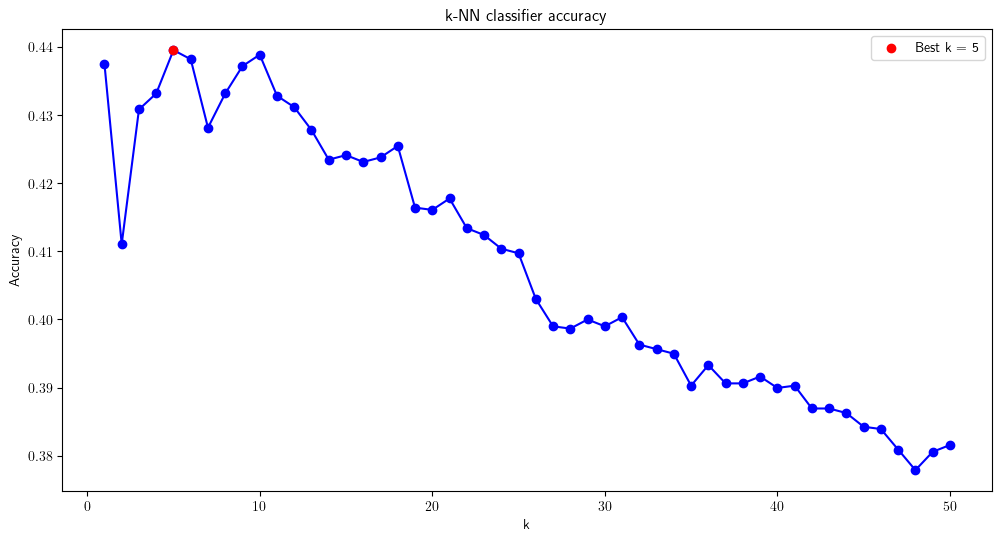

In [ ]:
# Test different values of k neighbors
k_values = range(1, 51)
accuracies = []
for k_ in tqdm.tqdm(k_values, desc="Testing k-NN values", leave=False):

	# Train k-NN classifier
	knn = KNeighborsClassifier(n_neighbors=k_)
	knn.fit(train_histograms["grid"], train_labels)

	# Predict labels for test set
	test_predictions = knn.predict(test_histograms["grid"])

	# Calculate accuracy
	accuracy = accuracy_score(test_labels, test_predictions)
	accuracies.append(accuracy)

# Best k
best_k = k_values[np.argmax(accuracies)]
print(f"Best k: {best_k}")

# Plot the accuracy for different values of k
plt.figure(figsize=(12, 6))
plt.plot(k_values, accuracies, marker='o', color='blue')

# Highlight the best k
plt.scatter(best_k, max(accuracies), color='red', zorder=5, label=f"Best k = {best_k}")

plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('k-NN classifier accuracy')
plt.legend()
plt.show()


Hence, as done for the previous we could do it for all representations.

In [ ]:
# Evaluation function for k-NN classifier
def evaluate_knn(train, test, train_labels, test_labels, k_values):
	
	# Find best k first
	accuracies = []
	for k_ in k_values:
		knn = KNeighborsClassifier(n_neighbors=k_)
		knn.fit(train, train_labels)
		predictions = knn.predict(test)
		accuracy = accuracy_score(test_labels, predictions)
		accuracies.append(accuracy)
	best_k = k_values[np.argmax(accuracies)]
 
	# Train k-NN classifier
	knn = KNeighborsClassifier(n_neighbors=best_k)
	knn.fit(train, train_labels)
 
	# Test k-NN classifier
	predictions = knn.predict(test)
	accuracy = accuracy_score(test_labels, predictions)

	return accuracy, best_k

# Evaluate k-NN classifier for all representations
print(f"Classifier".ljust(20), f"|\tRepresentation".ljust(30), f"|\tDetected".ljust(20), f"|\tGrid".ljust(20))
print("-" * 100)

k_values = range(1, 51)
for name, train, test in zip(names, train_representations, test_representations):
	result_string = f"k-NN".ljust(21) + f"|\t{name}".ljust(31)
	for key in train:
		accuracy, best_k = evaluate_knn(train[key], test[key], train_labels, test_labels, k_values)
		results["knn"][key][name] = accuracy
		result_string += f"|\t{accuracy * 100:.2f}% with k={best_k}".ljust(21)
	print(result_string)

Classifier           |	Representation               |	Detected           |	Grid              
----------------------------------------------------------------------------------------------------
k-NN                 |	Normalized Histogram         |	37.19% with k=13   |	43.95% with k=5    
k-NN                 |	TF-IDF                       |	36.42% with k=14   |	42.18% with k=8    
k-NN                 |	Kernel Codebook              |	38.93% with k=25   |	50.69% with k=11   
k-NN                 |	Codeword Uncertainty         |	42.31% with k=17   |	53.94% with k=17   
k-NN                 |	Codeword Plausibility        |	43.05% with k=25   |	54.77% with k=34   


Results seems promising, but we can also look at the confusion matrix, at least for the normalized histogram representation using grid sampling. From above, the best $k$ was $k=5$ in this case.

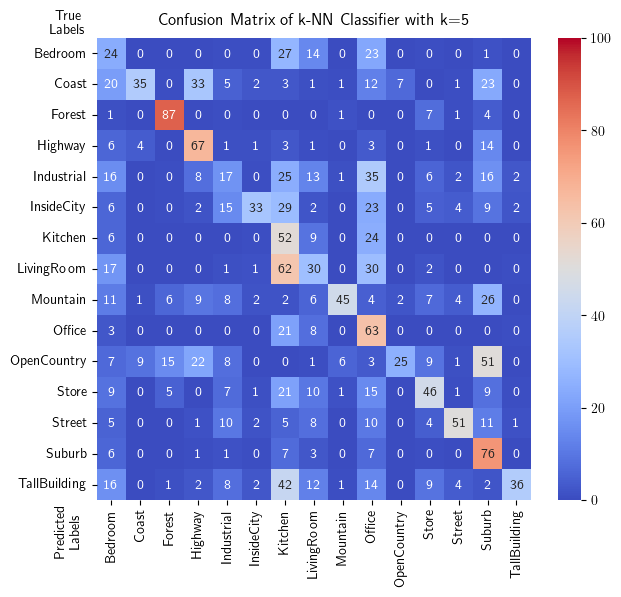

In [ ]:
# KNN classifier
best_k = 5
train = train_histograms["grid"]
test = test_histograms["grid"]
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(train, train_labels)
predictions = knn.predict(test)

# KNN confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions)
conf_matrix = conf_matrix / np.sum(conf_matrix, axis=1)

# Plot
fig = plt.figure(figsize=(7, 6))
sns.heatmap(
	conf_matrix * 100,
	annot=True, 
	fmt='.0f', 
	vmin = 0,
	vmax = 100,
	cmap='coolwarm', 
	cbar=True,
	xticklabels=classes, 
	yticklabels=classes,
)
plt.text(-1, 16, 'Predicted\nLabels', ha='center', va='center', rotation=90)
plt.text(-1, -0.5, 'True\nLabels', ha='center', va='center')
plt.title(f'Confusion Matrix of k-NN Classifier with k={best_k}', pad=10)
plt.show()


### Support Vector Machine (SVM) Classifiers

We can now try to achieve better results employing Support Vector Machine (SVM) classifiers with different inputs and kernels.\
All the implemented classifiers in this prject follow however the *one-vs-all* strategy, that is we first train $15$ different SVM classifiers, one for each class, using correctly modified ground truth labels. Then in the prediction phase, we assign to the test image the class corresponding to the SVM classifier that outputs the highest confidence score.\
Different kernels have been tested, including: RBF (default), $\chi^2$ kernel (`scikit-learn` implementation), histogram intersection kernel (from `utils.py`).\
A single evaluation function is sufficient to reproduce the results. The difference when doing the training with the default kernel with respect to other kernels only lies in the kernel parameter, which is set to the default value `rbf` for the RBF kernel and to `precomputed` for the other kernels. When we set the kernel to `precomputed` we need to pass the train Gram matrix as input to the `fit()` method and the test Gram matrix as input to the `descision_function()` method to get thescores. Both matrices are computed using the corresponding kernel functions.

In [ ]:
# SVM evaluation function
def evaluate_SVM(train, test, train_labels, test_labels, kernel='rbf'):

	# Train multiple SVM classifier with one-vs-all strategy
	SVMs = []
	for target_label in set(train_labels):
	 
		# Target label is 1, all others are -1
		one_vs_all_labels = [1 if label == target_label else -1 for label in train_labels]
  
		# Train SVM classifier
		svm = SVC(probability=True, C=1.0, kernel=kernel)
		svm.fit(train, one_vs_all_labels)
  
		# Store the SVM classifier
		SVMs.append(svm)
  
	# Compute predictions by collecting the values of the decision function
	# of each SVM classifier
	predictions = np.array([svm.decision_function(test) for svm in SVMs])
 
	# The final prediciton will be the one of the classifier with the highest
	# score value (so the index of the maximum value)
	predictions = np.argmax(predictions, axis=0)
 
	# Finally compute the accuracy
	accuracy = accuracy_score(test_labels, predictions)
 
	return accuracy

Using the RBF kernel.

In [ ]:
print(f"Classifier".ljust(20), f"|\tRepresentation".ljust(30), f"|\tDetected".ljust(20), f"|\tGrid".ljust(20))

# SVM with RBF kernel
print("-" * 100)
for name, train, test in zip(names, train_representations, test_representations):
	result_string = f"SVM (RBF)".ljust(21) + f"|\t{name}".ljust(31)
	for key in train:
		accuracy = evaluate_SVM(train[key], test[key], train_labels, test_labels, kernel='rbf')
		results["svm_rbf"][key][name] = accuracy
		result_string += f"|\t{accuracy * 100:.2f}%".ljust(21)
	print(result_string)

Classifier           |	Representation               |	Detected           |	Grid              
----------------------------------------------------------------------------------------------------
SVM (RBF)            |	Normalized Histogram         |	50.65%             |	66.43%             
SVM (RBF)            |	TF-IDF                       |	50.89%             |	62.65%             
SVM (RBF)            |	Kernel Codebook              |	54.77%             |	60.87%             
SVM (RBF)            |	Codeword Uncertainty         |	56.08%             |	64.86%             
SVM (RBF)            |	Codeword Plausibility        |	51.39%             |	65.13%             


Using the $\chi^2$ kernel.

In [ ]:
print(f"Classifier".ljust(20), f"|\tRepresentation".ljust(30), f"|\tDetected".ljust(20), f"|\tGrid".ljust(20))

# SVM with chi2 kernel
print("-" * 100)
for name, train, test in zip(names, train_representations, test_representations):
	result_string = f"SVM (chi2)".ljust(21) + f"|\t{name}".ljust(31)
	for key in train:
		train_gram = chi2_kernel(train[key], train[key])
		test_gram = chi2_kernel(test[key], train[key])
		accuracy = evaluate_SVM(train_gram, test_gram, train_labels, test_labels, kernel='precomputed')
		results["svm_chi2"][key][name] = accuracy
		result_string += f"|\t{accuracy * 100:.2f}%".ljust(21)
	print(result_string)

Classifier           |	Representation               |	Detected           |	Grid              
----------------------------------------------------------------------------------------------------
SVM (chi2)           |	Normalized Histogram         |	52.66%             |	71.42%             
SVM (chi2)           |	TF-IDF                       |	52.03%             |	70.22%             
SVM (chi2)           |	Kernel Codebook              |	53.94%             |	60.03%             
SVM (chi2)           |	Codeword Uncertainty         |	54.37%             |	63.05%             
SVM (chi2)           |	Codeword Plausibility        |	45.06%             |	58.46%             


Using the histogram intersection kernel.

In [ ]:
print(f"Classifier".ljust(20), f"|\tRepresentation".ljust(30), f"|\tDetected".ljust(20), f"|\tGrid".ljust(20))

# SVM with intersection kernel
print("-" * 100)
for name, train, test in zip(names, train_representations, test_representations):
	result_string = f"SVM (intersection)".ljust(21) + f"|\t{name}".ljust(31)
	for key in train:
		train_gram = intersection_kernel(train[key], train[key])
		test_gram = intersection_kernel(test[key], train[key])
		accuracy = evaluate_SVM(train_gram, test_gram, train_labels, test_labels, kernel='precomputed')
		results["svm_intersection"][key][name] = accuracy
		result_string += f"|\t{accuracy * 100:.2f}%".ljust(21)
	print(result_string)

Classifier           |	Representation               |	Detected           |	Grid              
----------------------------------------------------------------------------------------------------
SVM (intersection)   |	Normalized Histogram         |	50.95%             |	70.62%             
SVM (intersection)   |	TF-IDF                       |	50.79%             |	68.91%             
SVM (intersection)   |	Kernel Codebook              |	52.23%             |	60.34%             
SVM (intersection)   |	Codeword Uncertainty         |	53.37%             |	63.79%             
SVM (intersection)   |	Codeword Plausibility        |	49.15%             |	60.47%             


For the case of the normalized histogram representation with grid sampling, we also plot the confusion matrices in the $3$ cases to compare them.

In [ ]:
# Utility fucntion for simplicity (same idea as above)
def predictions_SVM(train, test, train_labels, test_labels, kernel='rbf'):
	SVMs = []
	for target_label in set(train_labels):
		one_vs_all_labels = [1 if label == target_label else -1 for label in train_labels]
		svm = SVC(probability=True, C=1.0, kernel=kernel)
		svm.fit(train, one_vs_all_labels)
		SVMs.append(svm)
	predictions = np.array([svm.decision_function(test) for svm in SVMs])
	predictions = np.argmax(predictions, axis=0)
	return predictions

train = train_histograms["grid"]
test = test_histograms["grid"]

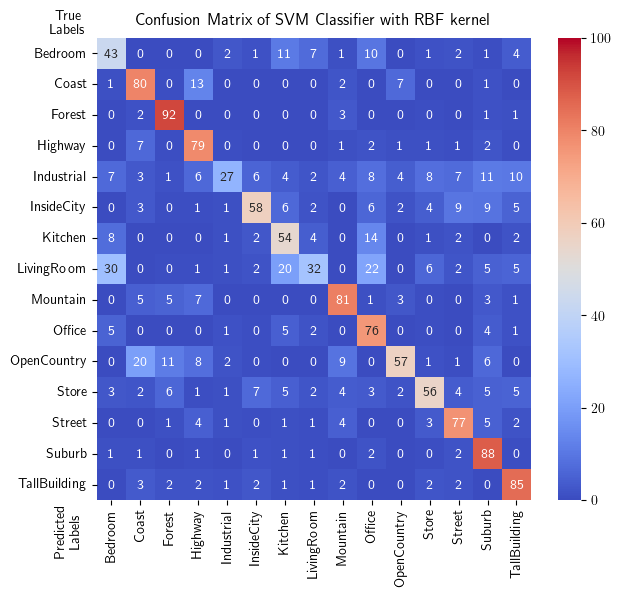

In [ ]:
# Confusion matrix for RBF kernel
predictions = predictions_SVM(train, test, train_labels, test_labels, kernel='rbf')
conf_matrix = confusion_matrix(test_labels, predictions)
conf_matrix = conf_matrix / np.sum(conf_matrix, axis=1)

# Plot
fig = plt.figure(figsize=(7, 6))
sns.heatmap(
	conf_matrix * 100,
	annot=True, 
	fmt='.0f', 
	vmin = 0,
	vmax = 100,
	cmap='coolwarm', 
	cbar=True,
	xticklabels=classes, 
	yticklabels=classes,
)
plt.text(-1, 16, 'Predicted\nLabels', ha='center', va='center', rotation=90)
plt.text(-1, -0.5, 'True\nLabels', ha='center', va='center')
plt.title(f'Confusion Matrix of SVM Classifier with RBF kernel', pad=10)
plt.show()

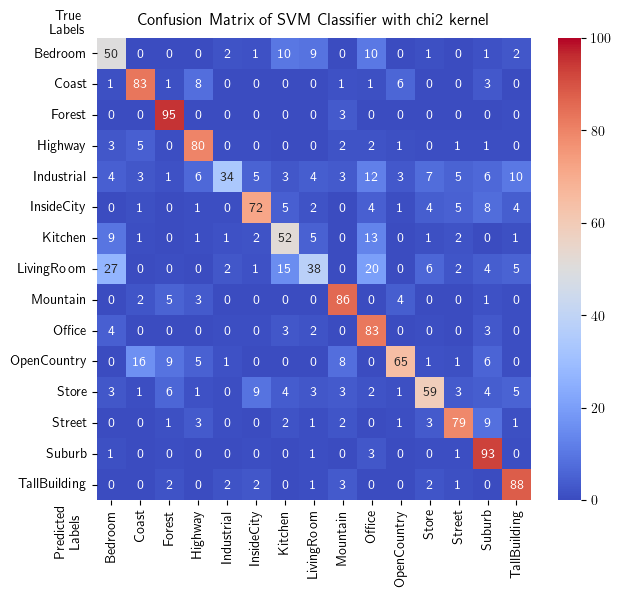

In [ ]:
# Confusion matrix for chi2 kernel
train_gram = chi2_kernel(train, train)
test_gram = chi2_kernel(test, train)
predictions = predictions_SVM(train_gram, test_gram, train_labels, test_labels, kernel='precomputed')
conf_matrix = confusion_matrix(test_labels, predictions)
conf_matrix = conf_matrix / np.sum(conf_matrix, axis=1)

# Plot
fig = plt.figure(figsize=(7, 6))
sns.heatmap(
	conf_matrix * 100,
	annot=True, 
	fmt='.0f', 
	vmin = 0,
	vmax = 100,
	cmap='coolwarm', 
	cbar=True,
	xticklabels=classes, 
	yticklabels=classes,
)
plt.text(-1, 16, 'Predicted\nLabels', ha='center', va='center', rotation=90)
plt.text(-1, -0.5, 'True\nLabels', ha='center', va='center')
plt.title(f'Confusion Matrix of SVM Classifier with chi2 kernel', pad=10)
plt.show()

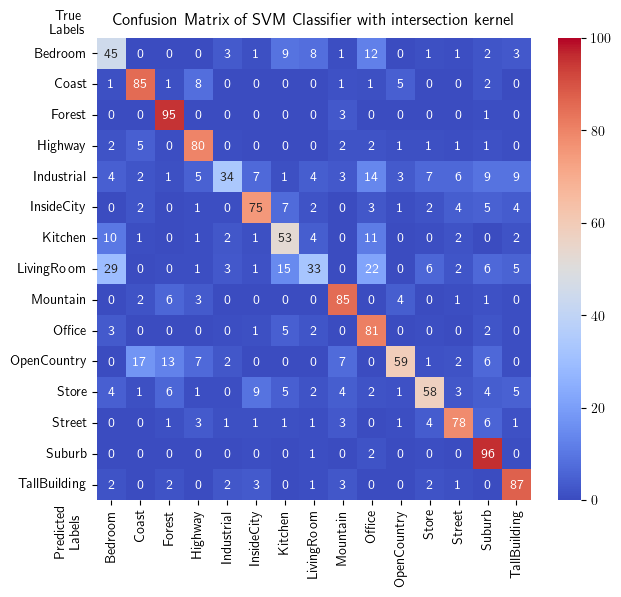

In [ ]:
# Confusion matrix for intersection kernel
train_gram = intersection_kernel(train, train)
test_gram = intersection_kernel(test, train)
predictions = predictions_SVM(train_gram, test_gram, train_labels, test_labels, kernel='precomputed')
conf_matrix = confusion_matrix(test_labels, predictions)
conf_matrix = conf_matrix / np.sum(conf_matrix, axis=1)

# Plot
fig = plt.figure(figsize=(7, 6))
sns.heatmap(
	conf_matrix * 100,
	annot=True, 
	fmt='.0f', 
	vmin = 0,
	vmax = 100,
	cmap='coolwarm', 
	cbar=True,
	xticklabels=classes, 
	yticklabels=classes,
)
plt.text(-1, 16, 'Predicted\nLabels', ha='center', va='center', rotation=90)
plt.text(-1, -0.5, 'True\nLabels', ha='center', va='center')
plt.title(f'Confusion Matrix of SVM Classifier with intersection kernel', pad=10)
plt.show()

Results are good in all cases but clearly better with the specialized kernels

### SVMs with Spatial Pyramid Matching

Finally, we can try to improve the performance of the classifier by adding spatial information to the Bag of Visual Words model. As explained by *Lazebnik et al.*, this can be done by dividing the image into a certain number of spatial regions (by building grids at different levels) and then computing the histograms of visual words for each region. The final representation of the image is then obtained by concatenating all the histograms of the idfferent regions.\
Moreover, a weight is assigned to the histograms from different resolution level, with higher weigths assigned to the histograms of finer grids and lower weights to the histograms of coarser grids.\
We now train and test the SVM classifiers with the spatial pyramid matching representation that uses levels from $0$ to $2$. Thank to the pre-applied weighting scheme the pyramid matching kernel simply reduces to a simple histogram intersection operation as done below (the cell still might take some time due to the high dimensionality of this representation...).

In [ ]:
# SVM with pyramid matching kernel
print(f"Classifier".ljust(20), f"|\tRepresentation".ljust(30), f"|\tDetected".ljust(20), f"|\tGrid".ljust(20))
print("-" * 100)
train_gram = intersection_kernel(train_pyramid["grid"], train_pyramid["grid"])
test_gram = intersection_kernel(test_pyramid["grid"], train_pyramid["grid"])
accuracy = evaluate_SVM(train_gram, test_gram, train_labels, test_labels, kernel='precomputed')
results["svm_pyramid"]["grid"]["Pyramid"] = accuracy
print(f"SVM (pyramid)".ljust(21) + f"|\tPyramid Histogram".ljust(31) + f"|\t --- ".ljust(21) + f"|\t{accuracy * 100:.2f}%".ljust(21))

Classifier           |	Representation               |	Detected           |	Grid              
----------------------------------------------------------------------------------------------------
SVM (pyramid)        |	Pyramid Histogram            |	 ---               |	75.54%             


Although we didn't quite reach the results shown by *Lazebnik et al.* in their paper, we can clearly see that this approach outperforms the previous ones, with an average accuracy of $75.54\%$ on the testing set. The associated confusion matrix is the following.

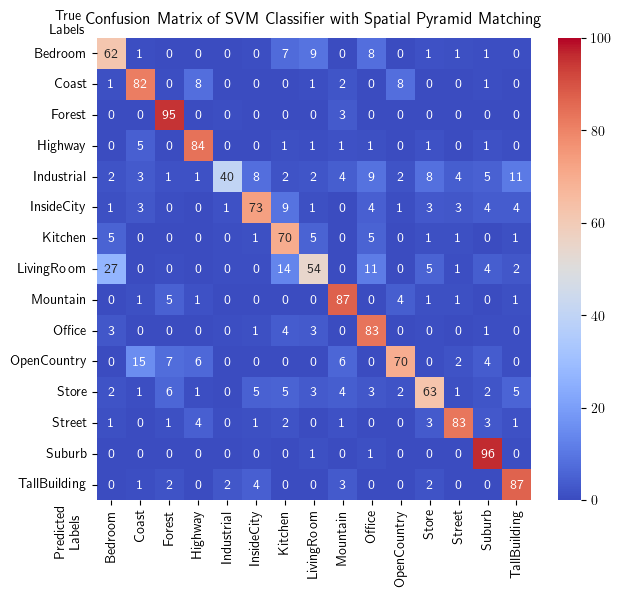

In [ ]:
train_gram = intersection_kernel(train_pyramid["grid"], train_pyramid["grid"])
test_gram = intersection_kernel(test_pyramid["grid"], train_pyramid["grid"])
predictions = predictions_SVM(train_gram, test_gram, train_labels, test_labels, kernel='precomputed')
conf_matrix = confusion_matrix(test_labels, predictions)
conf_matrix = conf_matrix / np.sum(conf_matrix, axis=1)

# Plot
fig = plt.figure(figsize=(7, 6))

sns.heatmap(
	conf_matrix * 100,
	annot=True, 
	fmt='.0f', 
	vmin = 0,
	vmax = 100,
	cmap='coolwarm', 
	cbar=True,
	xticklabels=classes, 
	yticklabels=classes,
)
plt.text(-1, 16, 'Predicted\nLabels', ha='center', va='center', rotation=90)
plt.text(-1, -0.5, 'True\nLabels', ha='center', va='center')
plt.title(f'Confusion Matrix of SVM Classifier with Spatial Pyramid Matching', pad=10)
plt.show()

## Results

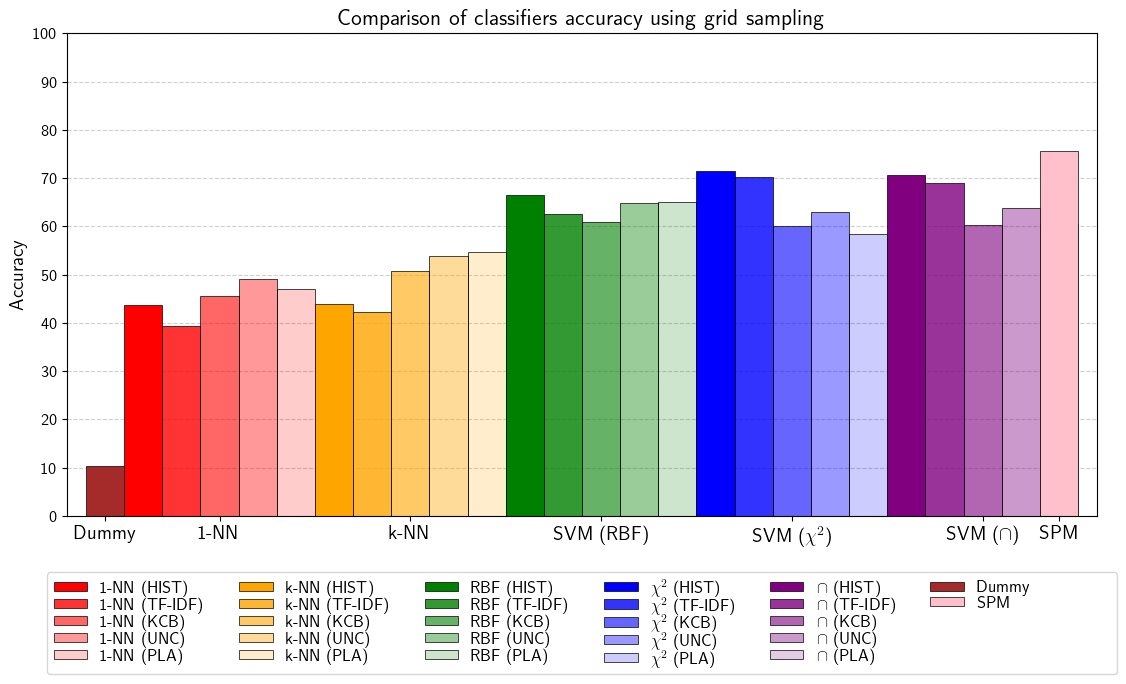

: 

In [ ]:

# Plot of the results corresponding to  grid sampling
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

# Create a color palette for each classifier (7 in total)
from matplotlib.colors import to_rgba
def create_palette(base_color, n_shades):
    base_rgba = to_rgba(base_color)
    return [(*base_rgba[:3], alpha) for alpha in np.linspace(0.2, 1, n_shades)]

# Define base colors and labels
base_colors = ['brown', 'red', 'orange', 'green', 'blue', 'purple', 'pink']
n_shades = 5
label_names = ["HIST", "TF-IDF", "KCB", "UNC", "PLA"]
palettes = [create_palette(color, n_shades) for color in base_colors]

# Plot the results
ax.set_title("Comparison of classifiers accuracy using grid sampling", fontsize=16)
ax.set_ylim(0, 100)
ax.set_xlim(-0.25, 6.5)
ax.set_ylabel("Accuracy", fontsize=14)
ax.set_xticks([0, 0.75, 2, 3.25, 4.5, 5.75, 6.25])
ax.set_xticklabels(["Dummy", "1-NN", "k-NN", "SVM (RBF)", r"SVM ($\chi^2$)", r"SVM ($\cap$)", "SPM"], fontsize=14)
ax.set_yticks(range(0, 101, 10))
ax.set_yticklabels([f"{i}" for i in range(0, 101, 10)], fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.6, zorder = 1)

# 1-NN classifier
for i, name in enumerate(names):
	ax.bar(
		x = 0.25*(i+1),
		height = 100*results["1nn"]["grid"][name],
		color = palettes[1][n_shades-i-1],
		width = 0.25,
		edgecolor = 'black',
		linewidth = 0.5,
		label = f"1-NN ({label_names[i]})",
		zorder = 2
	)
 
# k-NN classifier
for i, name in enumerate(names):
	ax.bar(
		x = (0.25*5*1) + 0.25*(i+1),
		height = 100*results["knn"]["grid"][name],
		color = palettes[2][n_shades-i-1],
		width = 0.25,
		edgecolor = 'black',
		linewidth = 0.5,
		label = f"k-NN ({label_names[i]})",
		zorder = 2
	)
 
 # SVM with RBF kernel
for i, name in enumerate(names):
	ax.bar(
		x = (0.25*5*2) + 0.25*(i+1),
		height = 100*results["svm_rbf"]["grid"][name],
		color = palettes[3][n_shades-i-1],
		width = 0.25,
		edgecolor = 'black',
		linewidth = 0.5,
		label = f"RBF ({label_names[i]})",
		zorder = 2
	)
 
# SVM with chi2 kernel
for i, name in enumerate(names):
	ax.bar(
		x = (0.25*5*3) + 0.25*(i+1),
		height = 100*results["svm_chi2"]["grid"][name],
		color = palettes[4][n_shades-i-1],
		width = 0.25,
		edgecolor = 'black',
		linewidth = 0.5,
		label = r"$\chi^2$" + f" ({label_names[i]})",
		zorder = 2
	)
 
# SVM with intersection kernel
for i, name in enumerate(names):
	ax.bar(
		x = (0.25*5*4) + 0.25*(i+1),
		height = 100*results["svm_intersection"]["grid"][name],
		color = palettes[5][n_shades-i-1],
		width = 0.25,
		edgecolor = 'black',
		linewidth = 0.5,
		label = r"$\cap$" + f" ({label_names[i]})",
		zorder = 2
	)

# Dummy classifier
ax.bar(
	x = 0,
	height = 100*results["dummy"]["grid"]["Normalized Histogram"],
	color = palettes[0][-1],
	width = 0.25,
	edgecolor = 'black',
	linewidth = 0.5,
	label = "Dummy",
	zorder = 2
)	

 
# SVM with pyramid matching kernel
ax.bar(
	x = (0.25*5*5),
	height = 100*results["svm_pyramid"]["grid"]["Pyramid"],
	color = palettes[6][-1],
	width = 0.25,
	edgecolor = 'black',
	linewidth = 0.5,
	label = "SPM",
	zorder = 2
)
  
# Legend (empty label only for aesthetic purposes)
ax.bar(0, 0, color='w', alpha=0, label=' ')
ax.bar(0, 0, color='w', alpha=0, label=' ')
ax.bar(0, 0, color='w', alpha=0, label=' ')
ax.bar(0, 0, color='w', alpha=0, label=' ')
ax.bar(0, 0, color='w', alpha=0, label=' ')
ax.bar(0, 0, color='w', alpha=0, label=' ')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=7, handleheight=0.5, labelspacing=0.025, fontsize=12)

# Save as pdf and show
plt.tight_layout()
plt.savefig("../report/images/classifiers_accuracy.pdf", bbox_inches='tight')

plt.show()